In [124]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [125]:
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'Marquisfg^1439', 
                  charset='utf8', use_unicode=True);

db_name = "spotify_songs"
table_name = "english_songs"

In [126]:
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT * FROM {db}.{table}".format(db=db_name, table=table_name))
rows = cur.fetchall()
cur.close()

songs_df = pd.DataFrame(list(rows))

In [127]:
e_songs_df = songs_df.dropna(subset=['lyrics'])

In [128]:
#names of the songs
NAMES = list(songs_df["song_name"])

#lyrics of the songs
lyrics = list(e_songs_df["lyrics"])

## Clustering

In [63]:
vectorizer = TfidfVectorizer(stop_words='english')
X_cluster = vectorizer.fit_transform(lyrics)

In [64]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()

Top terms per cluster:
Cluster 0:
 like
 wanna
 want
 happier
 crying
 got
 ve
 ain
 ll
 chorus

Cluster 1:
 chorus
 love
 ll
 baby
 instrumental
 cause
 don
 look
 just
 like

Cluster 2:
 oh
 ooh
 doo
 love
 yeah
 just
 chorus
 la
 ya
 ich

Cluster 3:
 nigga
 yeah
 shit
 uh
 like
 got
 ain
 niggas
 know
 don

Cluster 4:
 feat
 remix
 love
 lil
 lamar
 kendrick
 justin
 don
 drake
 big



# lyrics visualization

In [ ]:
for doc in labeled_corpus:
    words = filter(lambda x: x in model.vocab, doc.words)

In [167]:
# generate distributed representations of tokens that appear more than twice
min_count = 1
lyrics = songs_df['lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
#print(lyrics_tokenized[2])
model = Word2Vec(lyrics_tokenized, size=50, min_count=min_count, window=5)
#print(model.wv.vocab)
# create a list of tokens sorted by their frequency

count = CountVectorizer(stop_words='english')
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]
#print(list(words_sorted))
# project the word embeddings of top n_words_display words down to 2 dimensions
n_words_display = 200
words_sorted_ = []
for i in words_sorted:
    if i in model.wv.vocab:
        words_sorted_.append(i)
words_sorted = np.array(words_sorted_)
X = model[words_sorted[:n_words_display]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [168]:
# print most similar words to query_words
query_words = ['you', 'love', 'dance', 'oh', 'money']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

|      you      ||     love      ||     dance     ||      oh       ||     money     |
|       I       ||     know      ||      'em      ||      no       ||     shit      |
|     don't     ||       I       ||      his      ||      as       ||       a       |
|     know      ||      you      ||     over      ||      she      ||      and      |
|     when      ||     don't     ||      him      ||      at       ||     more      |
|      way      ||      way      ||     nigga     ||     It's      ||    [Outro]    |
|      But      ||     when      ||     Just      ||      She      ||      out      |
|      And      ||      And      ||      hit      ||     yeah      ||     When      |
|     wanna     ||     body      ||      an       ||    always     ||      as       |
|    'Cause     ||     want      ||      her      ||      out      ||     right     |
|   something   ||      But      ||     them      ||     from      ||      She      |


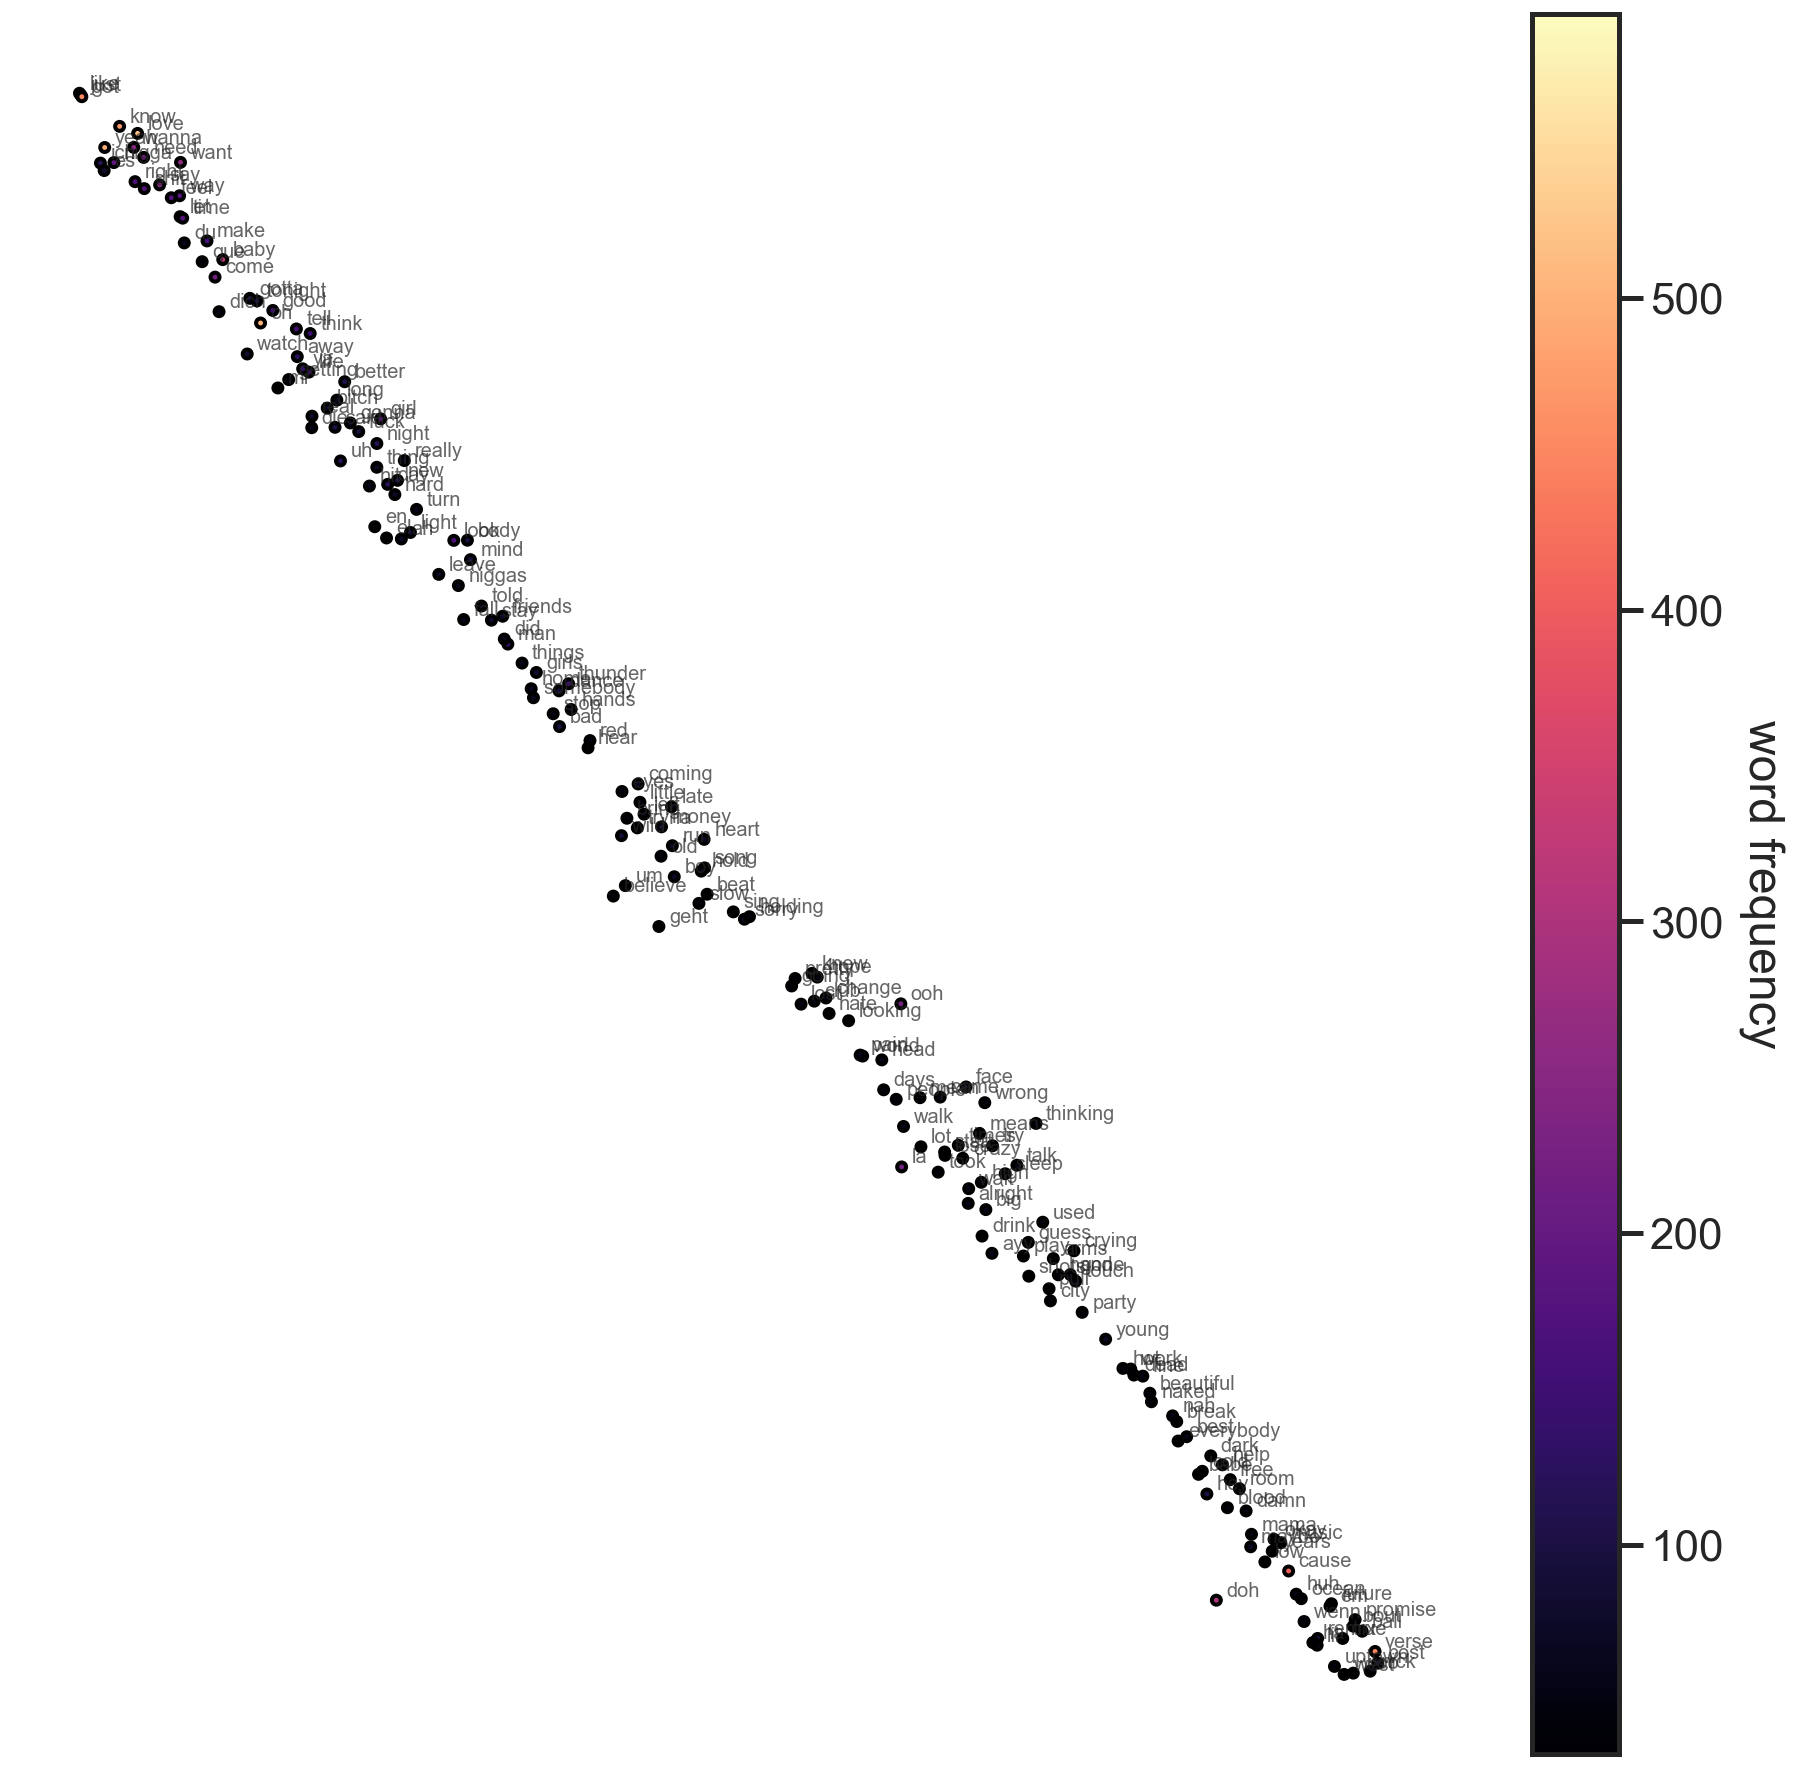

In [169]:
# plot 2D projections of top n_words_display words
plt.figure(figsize=(16,16))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)

In [170]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

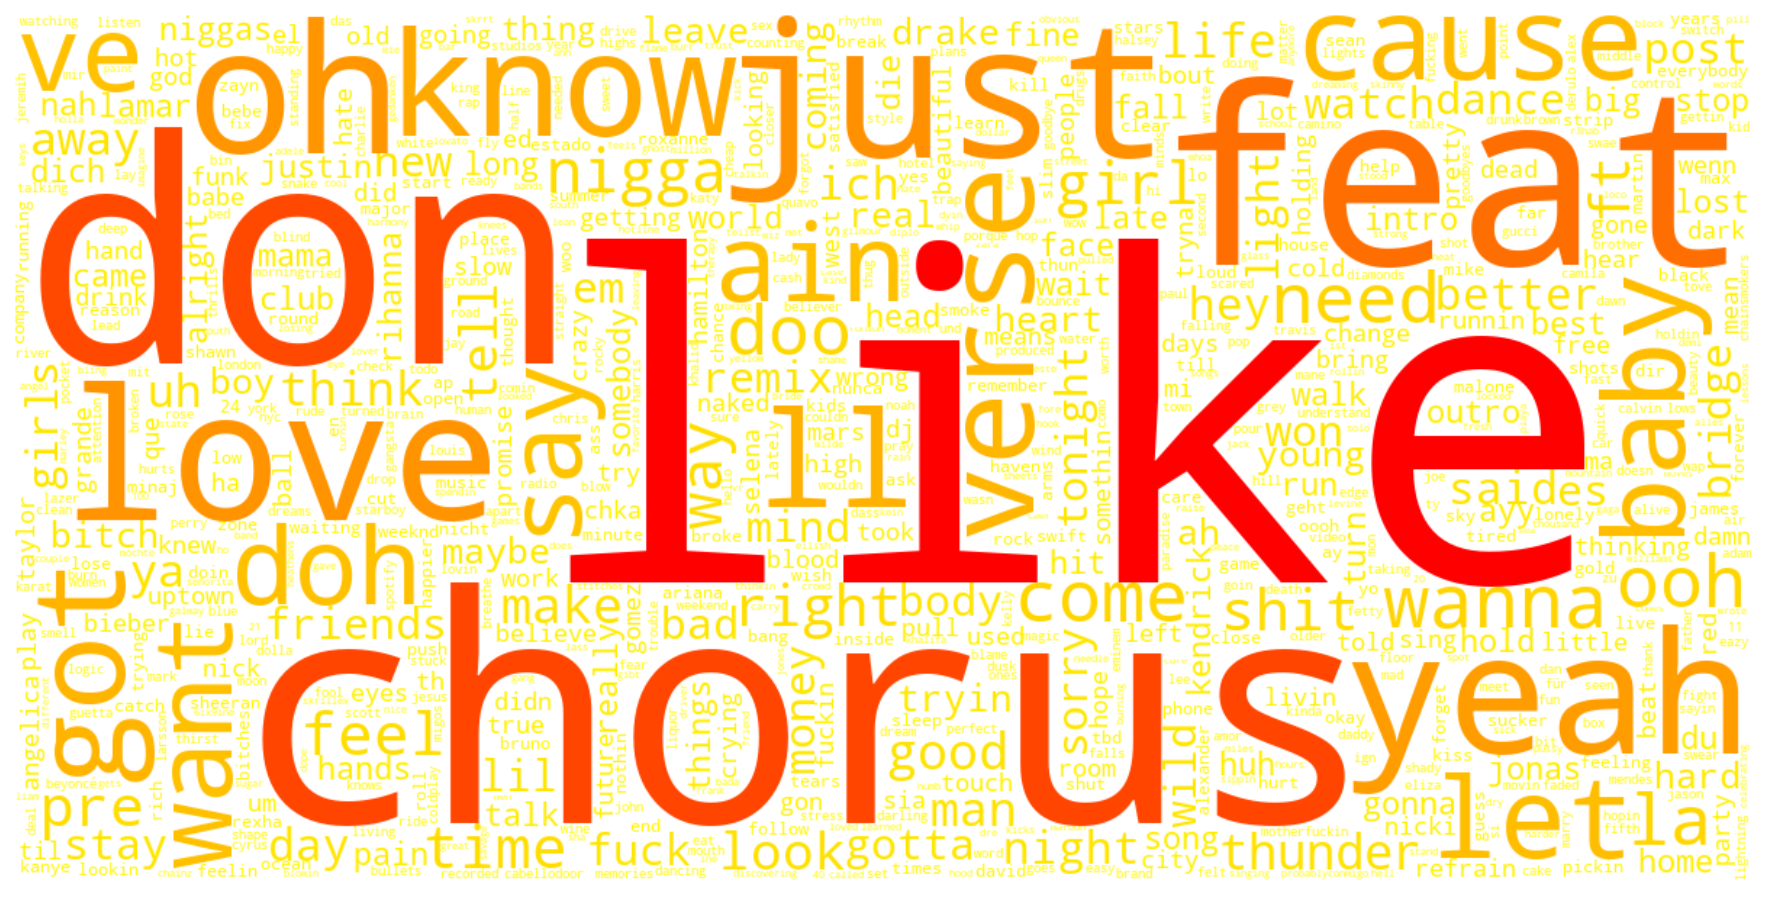

In [171]:
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('autumn_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

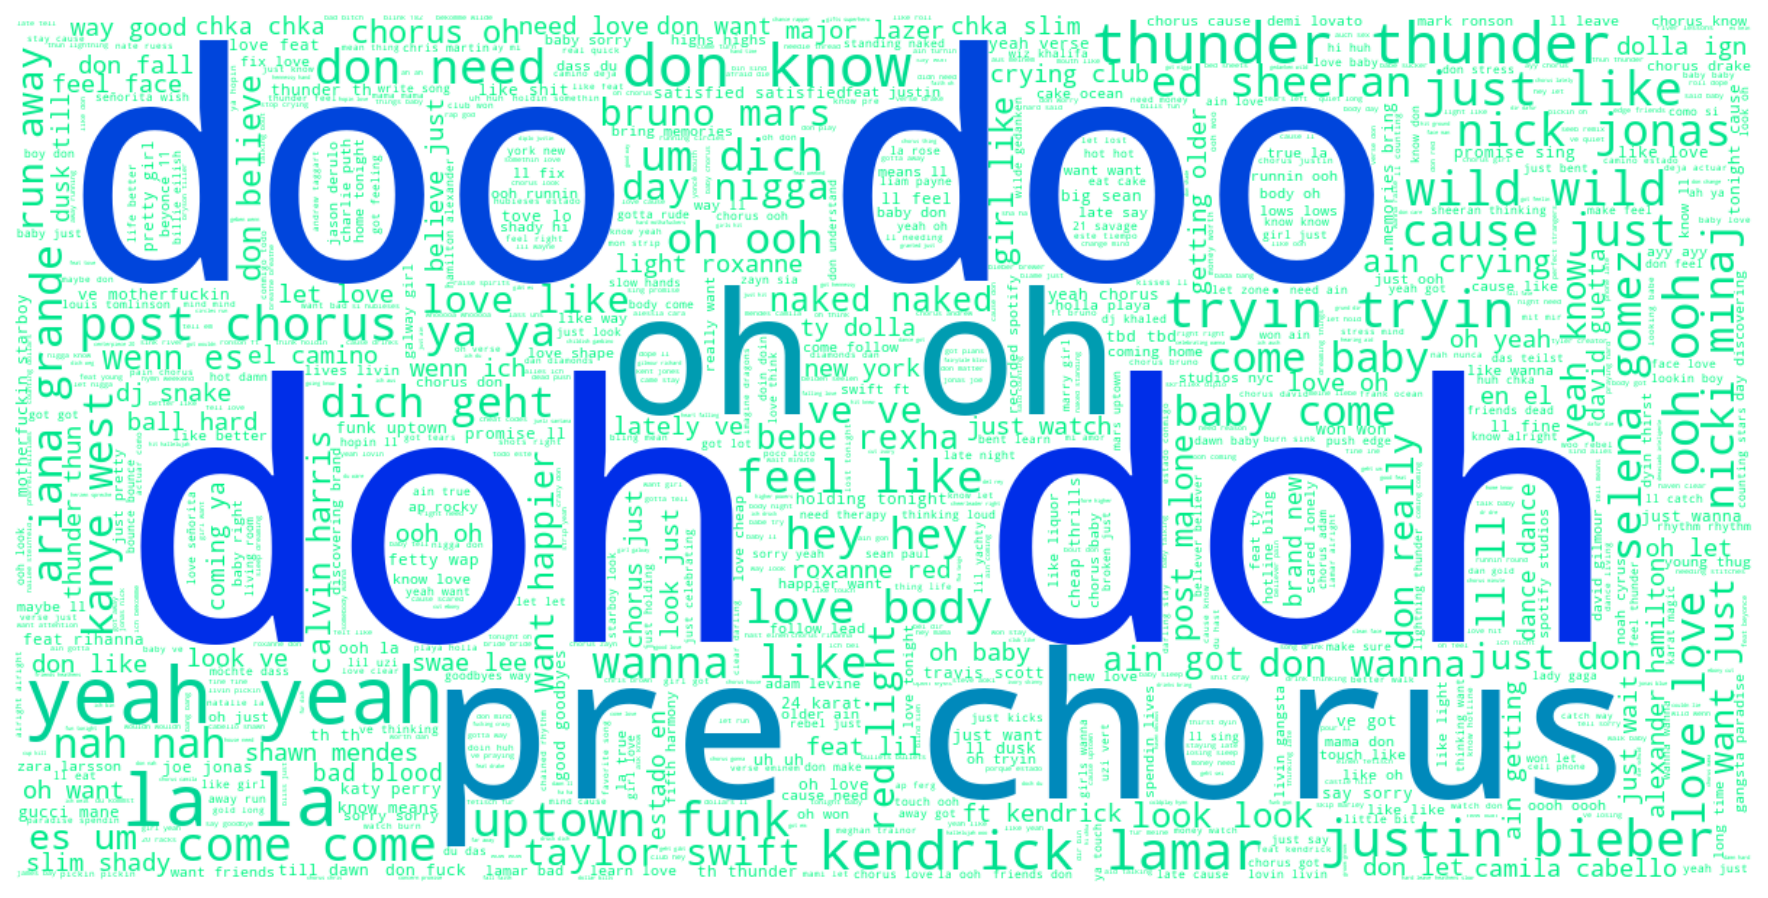

In [172]:
# calculate bigram frequencies
count_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))
count_bigrams.fit(lyrics)
freq_bigrams = np.array(
    count_bigrams.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count_bigrams.get_feature_names(), freq_bigrams))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

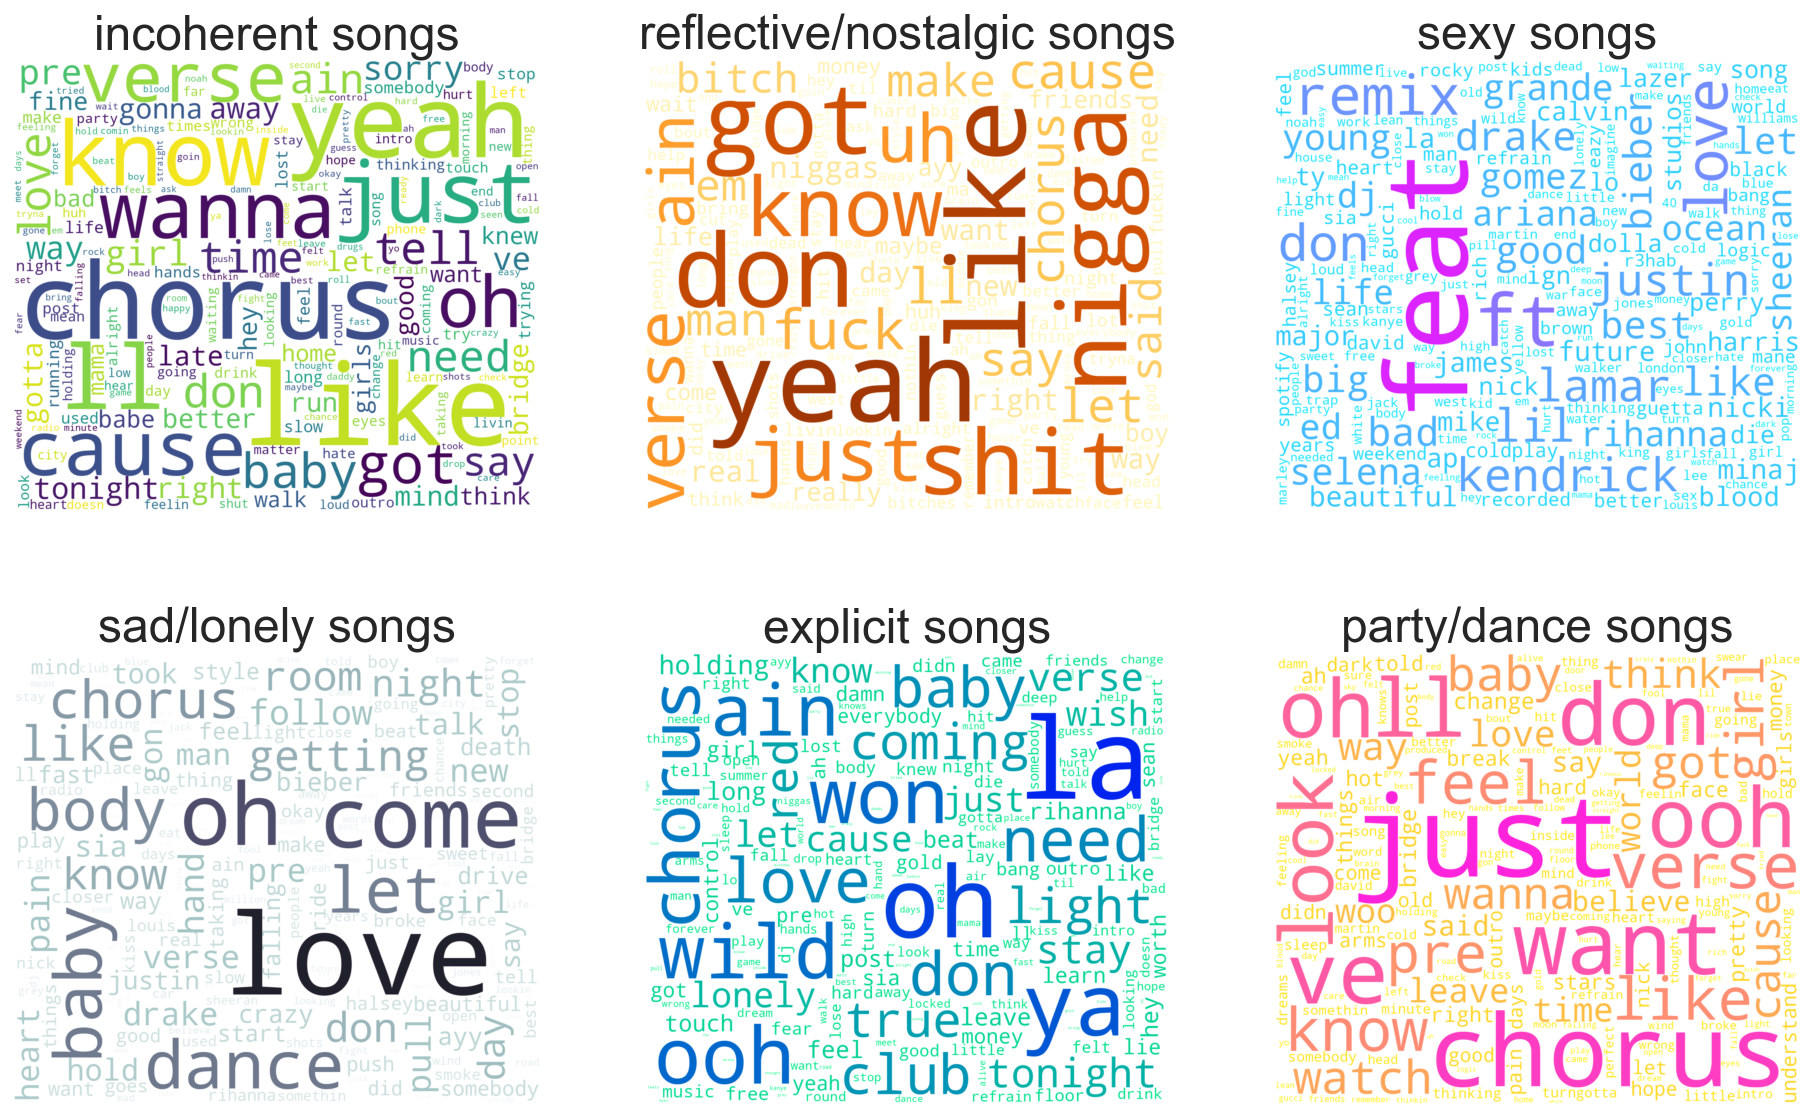

In [174]:
# convert lyrics to bag-of-words vectors
count = CountVectorizer(stop_words='english', min_df=10, max_df=500)
X_vect = count.fit_transform(np.array(lyrics))

# perform LDA and get the indices of top n_words_display words of each topic
n_topics = 6
n_words_display = 200
lda = LatentDirichletAllocation(n_components=n_topics)
X_lda = lda.fit_transform(X_vect)
indices = (-lda.components_).argsort(axis=1)[:,:n_words_display]
vocab = np.array(count.get_feature_names())

# generate subplot axes
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

# plot word clouds
topics = ['incoherent songs', 'reflective/nostalgic songs', 'sexy songs',
          'sad/lonely songs', 'explicit songs', 'party/dance songs']
cmaps = ['rainbow', 'YlOrBr', 'cool', 'bone_r', 'winter_r', 'spring_r']
for i in range(n_topics):
    if i == 0:
        color_func = None
    else:
        color_func = colormap_size_func(cmaps[i], 350)
    weights = lda.components_[i][indices[i]]
    words = vocab[indices[i,:]]
    dictionary = dict(zip(words, weights))
    wordcloud = WordCloud(background_color='white', height=1200, min_font_size=5,
                      width=1400, color_func=color_func,
                      max_words=n_words_display, relative_scaling=0.5,
                      max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title=topics[i])